# Проект: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

#### Цель исследования:
Подготовить модель машинного обучения для предсказания оттока клиентов. Проанализировать признаки, которые в большей степени влияют на разрыв договора, чтобы заранее находить таких пользователей и разарабобать стратегию их удержания.

#### Ход исследования:
1. Открыть и изучить предоставленные данные и подготовить их к исследованию. В нашем распоряжении 4 датасета, два из которых содержат данные о контрактах т персональную информацию обо всех клиентах, другие два предоставляют информацию о клиентах, кользующихся определенными пакетами - интернетом и стационарной телефонной связью. Информация о договорах актуальна на 1 февраля 2020 года.
2. Объединить данные из четырех датасетов.
3. Провести анализ полученного датасета и подготовить его к обучению.
4. Обучить несколько моделей и оценить их качество. Выбрать лучшую модель.
5. Проверить лучшую модель на тестовой выборке.
6. Сделать вывод.

## Загрузка данных

In [1]:
!pip install phik

In [2]:
!pip install --upgrade scikit-learn

In [77]:
# Имортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from lightgbm import LGBMClassifier 
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate


RANDOM_STATE = 111223

In [4]:
# Функция для получения первичной информации о датасете
def data_info(df):
    print('Размеры таблицы:', df.shape)
    print(df.head())
    print(df.info())

In [5]:
# Загрузим данные
data_contract = pd.read_csv('/datasets/contract_new.csv')
data_personal = pd.read_csv('/datasets/personal_new.csv')
data_internet = pd.read_csv('/datasets/internet_new.csv')
data_phone = pd.read_csv('/datasets/phone_new.csv')

In [6]:
data_info(data_contract)

Размеры таблицы: (7043, 8)
   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  

In [7]:
data_info(data_personal)

Размеры таблицы: (7043, 5)
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [8]:
data_info(data_internet)

Размеры таблицы: (5517, 8)
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   obj

In [9]:
data_info(data_phone)

Размеры таблицы: (6361, 2)
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


**Вывод:**
данные загружены, на первый взгляд, все корректно и соответствует документации. Пропуски в таблицах отсутствуют. Требуется предобработка - в некоторых столбцах, возможно, понадобится заменить тип данных, проверить данные на дубликаты, а так же выявить ключевой признак (ушел клиент из компании или нет). Ниже рассмотрим каждую таблицу подробнее.

## Исследовательский анализ и предобработка данных

### Файл contract_new.csv

In [10]:
# еще раз рассмотрим основную информацию о датасете
data_info(data_contract)

Размеры таблицы: (7043, 8)
   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  

Первая таблица содержит данные о контрактах клиентов. Всего 7043 строки и 8 столбцов. Практически все данные имеют тип object. 
Предварительно видны следующие моменты:
- На основании данных из EndDate сделаем целевой признак(target) для модели.
- Есть данные о начале (BeginDate) и окончании (EndDate) договоров, можем проследить их длительность и сформировать новый признак для обучения.
- Сами столбцы BeginDate и EndDate, содержащие даты, нам не понадобятся для обучения и могут вводить модель в заблуждение, их в последствии нужно будет исключить.
- Столбец TotalCharges, содержит информацию об общих расходах абонента, нужно будет поменять тип данных на float.

In [11]:
# Проверим данные на дубликаты
data_contract.duplicated().sum()

0

Поподробнее изучим столбец EndDate, содержащий информацию о дате окончания договора.

In [12]:
data_contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Здесь содержатся даты окончания договора и строка 'No', свидетельствующая о том, что человек все еще является клиентом компании. На основании этих данных добавим новую колонку к таблице, где 1 - клиент ушел(в строке содержится дата) и 0 - клиент остался(в строке содержится 'No').

In [13]:
# добавим в таблицу столбец exited с информацией о том, покинул клиент компанию или нет.
def categorize_type(row):
    if row['EndDate'] == 'No':
        return 0
    else:
        return 1
data_contract['exited'] = data_contract.apply(categorize_type, axis=1)
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


Целевой признак создан. Создадим еще один признак - длительность контракта ('contract_duration'). Для этого приведем столбцы BeginDate и EndDate к типу datetime, а 'No' заменим на '2020-02-01', т.к. именно на эту дату актуальны данные.

In [14]:
# замена 'No' на '2020-02-01'
data_contract.loc[data_contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [15]:
# изменение типа данных столбца 'EndDate'
data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'], format='%Y-%m-%d')

# изменение типа данных столбца 'BeginDate'
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'], format='%Y-%m-%d')

# создание нового признака 'contract_duration' в днях
data_contract['contract_duration'] = (data_contract['EndDate'] - data_contract['BeginDate']).dt.days

data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,contract_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


Изменим тип данных для столбца TotalCharges, но перед этим изучим данные в нем. Странно, что тип данных в этом столбце object, возможно есть пустые или содержащие буквенные символы строки.

In [16]:
data_contract['TotalCharges'].unique()

array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

In [17]:
data_contract.loc[data_contract['TotalCharges'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]')]['TotalCharges'].unique()

array([' '], dtype=object)

In [18]:
data_contract.loc[data_contract['TotalCharges'].str.contains(' ')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,contract_duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


Действительно обнаружились пустые строки. Причем это данные по абонентам, которые оформили контракт на услуги 2020-02-01 в дату, в которую были предоставлены данные. Скорее всего оплата еще не произошла, абонент еще не начал пользоваться услугами. В таком случае заполним эти строки 0, и преобразуем данные в тип float.

In [19]:
data_contract.loc[data_contract['TotalCharges'] == ' ', 'TotalCharges'] = 0
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype('float64')

С признаками закончили, теперь можно удалить столбцы BeginDate и EndDate.

In [20]:
data_contract = data_contract.drop(['BeginDate', 'EndDate'], axis=1)

display(data_contract.head())
data_contract.info()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,contract_duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   object 
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   exited             7043 non-null   int64  
 7   contract_duration  7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


Проверим оставшиеся столбцы на уникальные значения.

In [21]:
display(data_contract['Type'].unique())
display(data_contract['PaperlessBilling'].unique())
data_contract['PaymentMethod'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

**Вывод:**
Датасет data_contract предобработан, дубликатов не обнаружено. Созданы новые признаки - длительность контракта и целевой признак (ушел клиент или остался). Столбец TotalCharges приведен к типу float64, пустые строки заменены на 0. Также удалены признаки, содержащие даты.

### Файл personal_new.csv

In [22]:
# еще раз рассмотрим основную информацию о датасете
data_info(data_personal)

Размеры таблицы: (7043, 5)
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [23]:
# Проверим данные на дубликаты
data_personal.duplicated().sum()

0

Рассмотрим, какие уникальные значения содержат столбцы датасета

In [24]:
for i in data_personal.columns:
    print(f'Столбец {i} содержит следующие уникальные значения:{data_personal[i].unique()}')
    print('--------------------------')

Столбец customerID содержит следующие уникальные значения:['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
--------------------------
Столбец gender содержит следующие уникальные значения:['Female' 'Male']
--------------------------
Столбец SeniorCitizen содержит следующие уникальные значения:[0 1]
--------------------------
Столбец Partner содержит следующие уникальные значения:['Yes' 'No']
--------------------------
Столбец Dependents содержит следующие уникальные значения:['No' 'Yes']
--------------------------


Столбец SeniorCitizen содержит отличные от других категориальных признаков. Также отличается и тип данных. Приведем его к типу object.

In [25]:
data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].astype('object')
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


**Вывод:**
Датасет data_personal состоит из 7043 строк и 5 столбцов, и содержит персональные данные клиентов. Дубликатов обнаружено не было, пропусков тоже. Категориальный бинарный признак SeniorCitizen был преобразован в тип object.

### Файл internet_new.csv

In [26]:
# еще раз рассмотрим основную информацию о датасете
data_info(data_internet)

Размеры таблицы: (5517, 8)
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   obj

Датасет содержит 5517 строк и 8 столбцов с данными о клиентах, использующие интернет услуги компании. Пропуски на первый взгляд отсутствуют.

In [27]:
# Проверим данные на дубликаты
data_internet.duplicated().sum()

0

In [28]:
# Проверим уникальные значения в каждом столбце
for i in data_internet.columns:
    print(f'Столбец {i} содержит следующие уникальные значения:{data_internet[i].unique()}')
    print('--------------------------')

Столбец customerID содержит следующие уникальные значения:['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
--------------------------
Столбец InternetService содержит следующие уникальные значения:['DSL' 'Fiber optic']
--------------------------
Столбец OnlineSecurity содержит следующие уникальные значения:['No' 'Yes']
--------------------------
Столбец OnlineBackup содержит следующие уникальные значения:['Yes' 'No']
--------------------------
Столбец DeviceProtection содержит следующие уникальные значения:['No' 'Yes']
--------------------------
Столбец TechSupport содержит следующие уникальные значения:['No' 'Yes']
--------------------------
Столбец StreamingTV содержит следующие уникальные значения:['No' 'Yes']
--------------------------
Столбец StreamingMovies содержит следующие уникальные значения:['No' 'Yes']
--------------------------


**Вывод:**
Датасет data_personal состоит из 5517 строк и 8 столбцов, и содержит данные о клиентах, использующих интернет услуги компании. Дубликатов обнаружено не было, пропусков тоже. В дополнительной предобработке не нуждаются.

### Файл phone_new.csv

In [29]:
# еще раз рассмотрим основную информацию о датасете
data_info(data_phone)

Размеры таблицы: (6361, 2)
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


Датасет содержит 6361 строку и 2 столбца с данными о клиентах, использующие услуги стационарной телефонной связи. Пропуски на первый взгляд отсутствуют.

In [30]:
# Проверим данные на дубликаты
data_phone.duplicated().sum()

0

In [31]:
# Проверим уникальные значения в каждом столбце
for i in data_phone.columns:
    print(f'Столбец {i} содержит следующие уникальные значения:{data_phone[i].unique()}')
    print('--------------------------')

Столбец customerID содержит следующие уникальные значения:['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
--------------------------
Столбец MultipleLines содержит следующие уникальные значения:['No' 'Yes']
--------------------------


**Вывод:**
Датасет data_phone состоит из 6361 строки и 2 столбцов, и содержит данные о клиентах, использующих услуги стационарной телефонной связи. Дубликатов обнаружено не было, пропусков тоже. В дополнительной предобработке не нуждаются.

## Объединение данных

Объединение таблиц будем производить по общему ключу customerID (идентификатор клиента)

In [32]:
# Рассмотрим размеры каждой из таблиц
print(f'Размер таблицы data_contract: {data_contract.shape}')
print(f'Размер таблицы data_personal: {data_personal.shape}')
print(f'Размер таблицы data_internet: {data_internet.shape}')
print(f'Размер таблицы data_phone: {data_phone.shape}')

Размер таблицы data_contract: (7043, 8)
Размер таблицы data_personal: (7043, 5)
Размер таблицы data_internet: (5517, 8)
Размер таблицы data_phone: (6361, 2)


Первые две таблицы по условиям задачи должны иметь полную информацию обо всех клиентах. Не должно быть такого, что клиент присутствует в первой таблице, но не присутствует во второй. Значит, после их объединения, итоговая таблица должна содержать 7043 строки.  

In [33]:
data_full = data_contract.merge(data_personal, on='customerID', how='outer')
display(data_full.shape)
data_full.head()

(7043, 12)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,contract_duration,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No


Присоединение произошло корректно, присоединим еще 2 таблицы.

In [34]:
data_full = data_full.merge(data_internet, on='customerID', how='outer')
data_full = data_full.merge(data_phone, on='customerID', how='outer')

display(data_full.shape)
display(data_full.head())
data_full.info()

(7043, 20)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,contract_duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   object 
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   exited             7043 non-null   int64  
 7   contract_duration  7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   SeniorCitizen      7043 non-null   object 
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  InternetService    5517 non-null   object 
 13  OnlineSecurity     5517 non-null   object 
 14  OnlineBackup       5517 non-null   object 
 15  DeviceProtection   5517 non-null   object 
 16  TechSupport        5517 

In [35]:
# Проверим данные на дубликаты
data_full.duplicated().sum()

0

Объединение прошло успешно, данные не потеряли, новых пользователей, которых нет в двух первых таблицах, не приобрели. Однако, после объединения возникли пропуски в признаках из таблиц internet и phone, что ожидаемо, т.к. не все клиенты пользуются обоими пакетами услуг.

## Исследовательский анализ и предобработка данных объединённого датафрейма.

###### Обработка пропусков.

In [36]:
# Посмотрим на количество пропусков в столбцах
data_full.isna().sum()

customerID              0
Type                    0
PaperlessBilling        0
PaymentMethod           0
MonthlyCharges          0
TotalCharges            0
exited                  0
contract_duration       0
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
InternetService      1526
OnlineSecurity       1526
OnlineBackup         1526
DeviceProtection     1526
TechSupport          1526
StreamingTV          1526
StreamingMovies      1526
MultipleLines         682
dtype: int64

Пропусков получилось немало, но восстановлению они не подлежат, т.к. пропуск означает, что клиент попросту не пользуется данным пакетом, а значит и услугами, которые в него входят. Заменить их на 'No' будет также некорректно, поэтому заменим их на значение 'unknown'.

In [37]:
data_full = data_full.fillna('unknown')

In [38]:
data_full.isna().sum()

customerID           0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
exited               0
contract_duration    0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MultipleLines        0
dtype: int64

In [39]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   object 
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   exited             7043 non-null   int64  
 7   contract_duration  7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   SeniorCitizen      7043 non-null   int64  
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  InternetService    7043 non-null   object 
 13  OnlineSecurity     7043 non-null   object 
 14  OnlineBackup       7043 non-null   object 
 15  DeviceProtection   7043 non-null   object 
 16  TechSupport        7043 

In [40]:
data_full['SeniorCitizen'].unique()

array([0, 1])

In [41]:
data_full['SeniorCitizen'] = data_full['SeniorCitizen'].astype('object')
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   object 
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   exited             7043 non-null   int64  
 7   contract_duration  7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   SeniorCitizen      7043 non-null   object 
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  InternetService    7043 non-null   object 
 13  OnlineSecurity     7043 non-null   object 
 14  OnlineBackup       7043 non-null   object 
 15  DeviceProtection   7043 non-null   object 
 16  TechSupport        7043 

Теперь пропуски в таблице отсутствуют.

Также необходимо удалить столбец customerID, он нам не понадобится для обучения.

In [42]:
data_full = data_full.drop('customerID', axis=1)
data_full.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,contract_duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,unknown
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,unknown
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [43]:
# Проверим данные на дубликаты
data_full.duplicated().sum()

4

In [44]:
# Удалим найденные дубликаты
data_full = data_full.drop_duplicates().reset_index(drop=True)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7039 entries, 0 to 7038
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               7039 non-null   object 
 1   PaperlessBilling   7039 non-null   object 
 2   PaymentMethod      7039 non-null   object 
 3   MonthlyCharges     7039 non-null   float64
 4   TotalCharges       7039 non-null   float64
 5   exited             7039 non-null   int64  
 6   contract_duration  7039 non-null   int64  
 7   gender             7039 non-null   object 
 8   SeniorCitizen      7039 non-null   object 
 9   Partner            7039 non-null   object 
 10  Dependents         7039 non-null   object 
 11  InternetService    7039 non-null   object 
 12  OnlineSecurity     7039 non-null   object 
 13  OnlineBackup       7039 non-null   object 
 14  DeviceProtection   7039 non-null   object 
 15  TechSupport        7039 non-null   object 
 16  StreamingTV        7039 

###### Исследование корреляции признаков.

Исследуем корреляцию признаков с помощью библиотеки phik. Я планирую использовать линейную модель, для которой мультиколлинеарность будет проблемой. 

In [45]:
corr = data_full.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'contract_duration'])
corr

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,contract_duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
Type,1.000000,0.107076,0.277436,0.388268,0.470487,0.094073,0.633814,0.000000,0.086227,0.179447,0.147569,0.505769,0.637001,0.581839,0.631674,0.671733,0.549790,0.553779,0.243135
PaperlessBilling,0.107076,1.000000,0.369684,0.467047,0.201023,0.083159,0.025643,0.000000,0.241965,0.013973,0.173503,0.231074,0.207967,0.194901,0.195274,0.200237,0.204304,0.201824,0.099860
PaymentMethod,0.277436,0.369684,1.000000,0.398895,0.335398,0.214624,0.350860,0.000000,0.292447,0.242734,0.225051,0.323494,0.315245,0.292835,0.297348,0.317163,0.283987,0.284979,0.174813
MonthlyCharges,0.388268,0.467047,0.398895,1.000000,0.710537,0.226314,0.387011,0.010465,0.304860,0.203157,0.185158,0.918980,0.812553,0.818785,0.827209,0.816578,0.864636,0.863575,0.709954
TotalCharges,0.470487,0.201023,0.335398,0.710537,1.000000,0.302751,0.848304,0.000000,0.135556,0.381439,0.083553,0.489766,0.516243,0.550290,0.558149,0.527539,0.555088,0.553798,0.467550
exited,0.094073,0.083159,0.214624,0.226314,0.302751,1.000000,0.374361,0.009029,0.085995,0.226776,0.046841,0.056527,0.058587,0.089683,0.085582,0.051437,0.078503,0.086546,0.105152
contract_duration,0.633814,0.025643,0.350860,0.387011,0.848304,0.374361,1.000000,0.000000,0.063165,0.452940,0.198278,0.060400,0.346201,0.366058,0.374602,0.353258,0.306524,0.307153,0.346654
gender,0.000000,0.000000,0.000000,0.010465,0.000000,0.009029,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.086227,0.241965,0.292447,0.304860,0.135556,0.085995,0.063165,0.000000,1.000000,0.017018,0.324714,0.160675,0.127201,0.109890,0.110070,0.135167,0.111622,0.113693,0.087972
Partner,0.179447,0.013973,0.242734,0.203157,0.381439,0.226776,0.452940,0.000000,0.017018,1.000000,0.652047,0.000000,0.091110,0.091936,0.100019,0.076228,0.082180,0.077434,0.085937


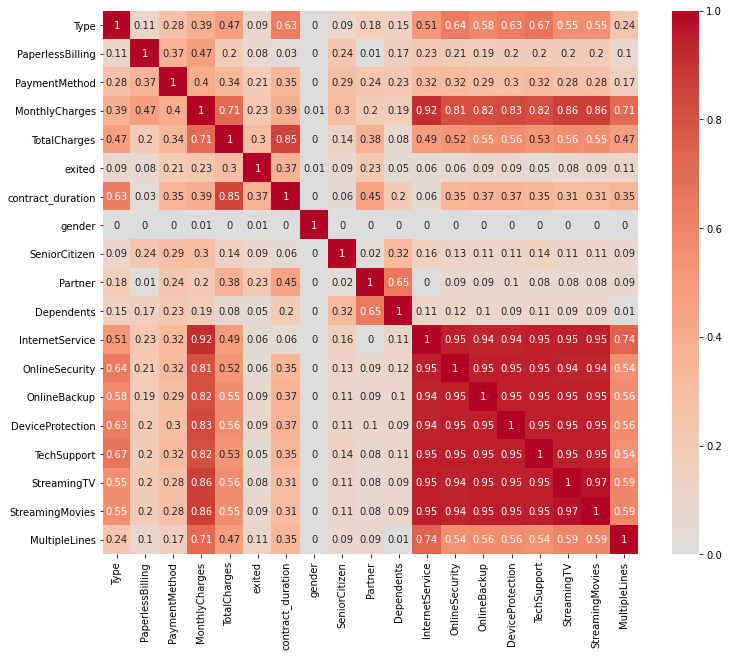

In [46]:
plt.figure(figsize = (12, 10))
sns.heatmap(corr.round(2), cmap='coolwarm', center=0, annot=True);

Прослеживается высокая зависимость между некоторыми предикторами - 0.9 и выше. Удалим по одному предиктору из пары сильно скоррелированных предикторов, оставим те, связь которых с таргетом выше. Удалим столбцы: InternetService( высокая корреляция с MonthlyCharges	и другими признаками из интернет пакета, и низкая с таргетом), OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies - по той же причине (высокая корреляция с расходами за месяц и очень маленькая с таргетом. Также удалим TotalCharges, т.к. есть явная высокая корреляция с новым признаком contract_duration (выбрала на основе наибольшей корреляции с таргетом)

На графике видно, что сильная зависимость, между таргетом (exited) и другими признаками отсутствует. Однако корреляция между таргетом и двумя признаками - полом(gender) клиента и наличием детей(Dependents) близка к 0 , значит зависимости между этими признаками нет. Этоти признаки можно удалить.
Остальные признаки, хоть и тоже в большинстве своем не показали высокую степень зависимости с таргетом, я оставляю, чтобы у моделей было достаточно информации для обучения.

In [47]:
data_full = data_full.drop(['gender', 'Dependents', 'InternetService', 'OnlineSecurity', 
                            'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                            'StreamingTV', 'StreamingMovies', 'TotalCharges'], axis=1)
data_full.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,exited,contract_duration,SeniorCitizen,Partner,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,0,31,0,Yes,unknown
1,One year,No,Mailed check,56.95,0,1036,0,No,No
2,Month-to-month,Yes,Mailed check,53.85,0,123,0,No,No
3,One year,No,Bank transfer (automatic),42.30,0,1371,0,No,unknown
4,Month-to-month,Yes,Electronic check,70.70,0,153,0,No,No


In [48]:
data_full.duplicated().sum()

55

In [49]:
data_full = data_full.drop_duplicates().reset_index(drop=True)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6984 entries, 0 to 6983
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               6984 non-null   object 
 1   PaperlessBilling   6984 non-null   object 
 2   PaymentMethod      6984 non-null   object 
 3   MonthlyCharges     6984 non-null   float64
 4   exited             6984 non-null   int64  
 5   contract_duration  6984 non-null   int64  
 6   SeniorCitizen      6984 non-null   object 
 7   Partner            6984 non-null   object 
 8   MultipleLines      6984 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 491.2+ KB


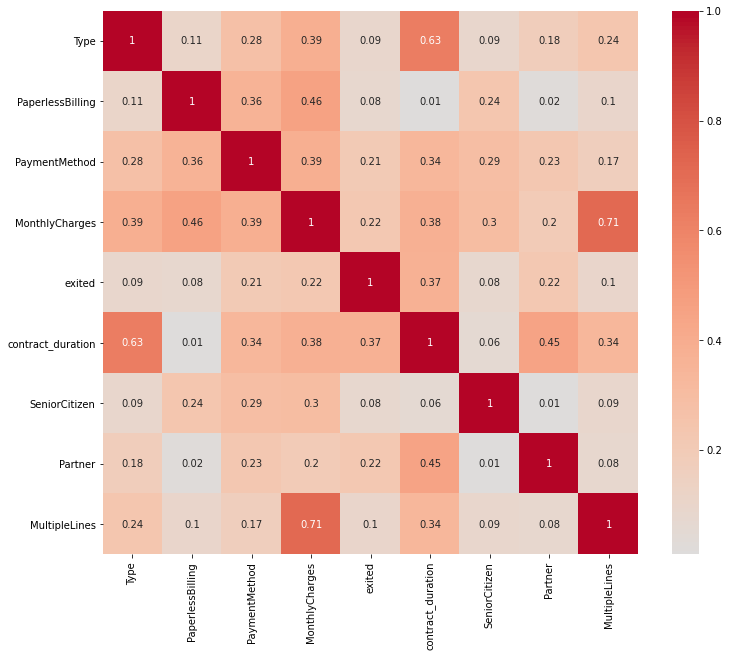

In [50]:
corr_new = data_full.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'contract_duration'])
plt.figure(figsize = (12, 10))
sns.heatmap(corr_new.round(2), cmap='coolwarm', center=0, annot=True);

Наиболее высокая зависимость целевой переменной наблюдается от признаков TotalCharges и contract_duration. посмотрим также на зависимость таргета от непрерывных признаков с помощью корреляции Пирсона.

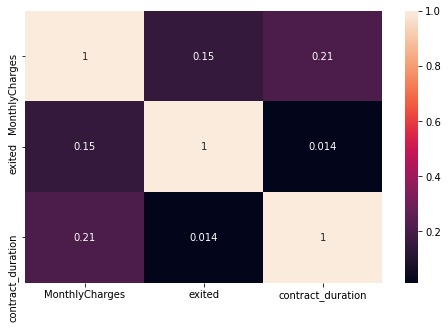

In [51]:
plt.figure(figsize = (8, 5))
sns.heatmap(data_full.corr(), annot=True);

Здесь мы видим, что наибольшая зависимость целевого признака наблюдается от признака MonthlyCharges (расходов за месяц). Корреляция положительная, значит с ростом расходов за месяц растет и вероятность ухода клиента.

###### Исследование баланса классов

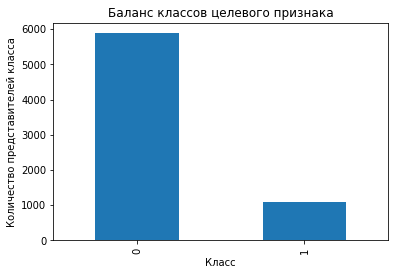

In [52]:
plt.title("Баланс классов целевого признака")
plt.xlabel("Класс")
plt.ylabel("Количество представителей класса")
data_full['exited'].value_counts().plot(kind='bar');

In [53]:
data_full['exited'].value_counts(normalize=True)

0    0.842354
1    0.157646
Name: exited, dtype: float64

In [54]:
for i in data_full.columns:
    print(f'Столбец {i} содержит следующие уникальные значения:{data_full[i].unique()}')
    print('--------------------------')

Столбец Type содержит следующие уникальные значения:['Month-to-month' 'One year' 'Two year']
--------------------------
Столбец PaperlessBilling содержит следующие уникальные значения:['Yes' 'No']
--------------------------
Столбец PaymentMethod содержит следующие уникальные значения:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
--------------------------
Столбец MonthlyCharges содержит следующие уникальные значения:[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
--------------------------
Столбец exited содержит следующие уникальные значения:[0 1]
--------------------------
Столбец contract_duration содержит следующие уникальные значения:[  31 1036  123 1371  153  337  671  306  945  882  396  488 1767 1614
  761  670 1584 2163  641   92  365 1492 1523 2191  610 1706   62  822
 1764  245 1401 1095  427 1948  518 1918 2102 1310 1826  580 2010 1432
 1246  549 1949 1888  914 1279  276 1067 1461  883  881  792 1157 1581
 1280  973 1248  184  215 1006

На графике четко виден большой дисбаланс классов, примено 85/15. Устранять этот дисбаланс не будем, т.к. планируем пользоваться  метрикой AUC-ROC, которая не чувствительна к дисбалансу. Да и уменьшение/увеличение выборки, как способ борьбы с дисбалансом, могут привести к нежелательным последствиям: данных будет либо очень мало, либо произойдет утечка на кросс-валидации.

**Вывод:**
В результате анализа и предобработки объединенного датасета были сделаны следующие шаги:
1. Найденные пропуски, заполнены константным значением. Причиной образования пропусков послужила объединение - не все клиенты компании используют оба тарифных пакета - интернет и стационарную телефонную связь.
2. Была изучена корреляция признаков от целевого признака. В результате были удалены два признака 'gender'(пол) и 'Dependents'(наличие детей), т.к. их влияние на таргет оказалось ничтожно мало, и не будет играть большой роли в построении предсказаний моделью.
3. Был изучен баланс классов. 

## Подготовка данных

Применим кодирование категориальных признаков. Будем использовать OHE для линейных моделей и Ordinal Encoding для "деревянных" моделей.

In [55]:
object_columns = data_full.select_dtypes(include=['object']).columns
object_columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner',
       'MultipleLines'],
      dtype='object')

Разделим данние на признаки и таргет.

In [56]:
features = data_full.drop('exited', axis=1)
target = data_full['exited']

display(features.shape)
display(target.shape)

(6984, 8)

(6984,)

Обучать модели будем с помощью кросс-валидации, поэтом валидационная выборка нам не понадобится. Разделим данные на обучающую и тестовую выборки в соотношении 3:1.

In [57]:
# Разделим данные на тренировочную и тестовую выборки.
# Чтобы соотношение классов в обоих выборках было равное, укажем параметр stratify
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=.25, 
                                                                            stratify=target, 
                                                                            random_state=RANDOM_STATE)

display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(5238, 8)

(5238,)

(1746, 8)

(1746,)

In [58]:
features_train = features_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(5238, 8)

(5238,)

(1746, 8)

(1746,)

In [59]:
encoder_ohe = OneHotEncoder(drop='first', sparse_output = False)

In [60]:
encoded_features_train_ohe = pd.DataFrame(encoder_ohe.fit_transform(features_train[object_columns]))
encoded_features_train_ohe.columns = encoder_ohe.get_feature_names_out(object_columns)
features_train_ohe = features_train.join(encoded_features_train_ohe)
features_train_ohe.drop(object_columns, axis = 1, inplace = True)

encoded_features_test_ohe = pd.DataFrame(encoder_ohe.transform(features_test[object_columns]))
encoded_features_test_ohe.columns = encoder_ohe.get_feature_names_out(object_columns)
features_test_ohe = features_test.join(encoded_features_test_ohe)
features_test_ohe.drop(object_columns, axis = 1, inplace = True)

display(features_train_ohe.head())
features_train_ohe.info()

display(features_test_ohe.head())
features_test_ohe.info()

,MonthlyCharges,contract_duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,MultipleLines_Yes,MultipleLines_unknown
0,80.65,2102,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,101.40,1158,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,101.90,577,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.00,245,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,24.90,62,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5238 entries, 0 to 5237
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5238 non-null   float64
 1   contract_duration                      5238 non-null   int64  
 2   Type_One year                          5238 non-null   float64
 3   Type_Two year                          5238 non-null   float64
 4   PaperlessBilling_Yes                   5238 non-null   float64
 5   PaymentMethod_Credit card (automatic)  5238 non-null   float64
 6   PaymentMethod_Electronic check         5238 non-null   float64
 7   PaymentMethod_Mailed check             5238 non-null   float64
 8   SeniorCitizen_1                        5238 non-null   float64
 9   Partner_Yes                            5238 non-null   float64
 10  MultipleLines_Yes                      5238 non-null   float64
 11  Mult

,MonthlyCharges,contract_duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,MultipleLines_Yes,MultipleLines_unknown
0,80.35,1523,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
1,59.55,2041,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,45.10,62,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,84.90,1095,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,54.50,1157,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746 entries, 0 to 1745
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         1746 non-null   float64
 1   contract_duration                      1746 non-null   int64  
 2   Type_One year                          1746 non-null   float64
 3   Type_Two year                          1746 non-null   float64
 4   PaperlessBilling_Yes                   1746 non-null   float64
 5   PaymentMethod_Credit card (automatic)  1746 non-null   float64
 6   PaymentMethod_Electronic check         1746 non-null   float64
 7   PaymentMethod_Mailed check             1746 non-null   float64
 8   SeniorCitizen_1                        1746 non-null   float64
 9   Partner_Yes                            1746 non-null   float64
 10  MultipleLines_Yes                      1746 non-null   float64
 11  Mult

Масштабируем непрерывные признаки с помощью StandardScaler()

In [61]:
numeric_columns = features.select_dtypes(include=['int64', 'float64' ]).columns
numeric_columns

Index(['MonthlyCharges', 'contract_duration'], dtype='object')

In [62]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric_columns])
features_train_ohe[numeric_columns] = scaler.transform(features_train_ohe[numeric_columns])
features_test_ohe[numeric_columns] = scaler.transform(features_test_ohe[numeric_columns])

display(features_train_ohe.shape)
display(features_train_ohe.head())
display(features_test_ohe.shape)
display(features_test_ohe.head())

(5238, 12)

,MonthlyCharges,contract_duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,MultipleLines_Yes,MultipleLines_unknown
0,0.524224,1.765531,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.214358,0.378102,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.230988,-0.475814,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.162584,-0.963766,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.329992,-1.232727,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


(1746, 12)

,MonthlyCharges,contract_duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,MultipleLines_Yes,MultipleLines_unknown
0,0.514246,0.914555,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
1,-0.177551,1.675877,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,-0.658150,-1.232727,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.665577,0.285508,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.345511,0.376632,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Подготовим данные с помощью Ordinal Encoder

In [63]:
features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

In [64]:
encoder_ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [65]:
encoder_ord.fit(features_train[object_columns])
features_train_ord[object_columns] = encoder_ord.transform(features_train_ord[object_columns])
features_test_ord[object_columns] = encoder_ord.transform(features_test_ord[object_columns])

display(features_train_ord.shape)
display(features_train_ord.head())
display(features_test_ord.shape)
display(features_test_ord.head())

(5238, 8)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,contract_duration,SeniorCitizen,Partner,MultipleLines
0,2.0,0.0,0.0,80.65,2102,0.0,1.0,0.0
1,0.0,1.0,1.0,101.40,1158,1.0,0.0,1.0
2,0.0,1.0,0.0,101.90,577,0.0,0.0,1.0
3,0.0,1.0,2.0,60.00,245,0.0,0.0,0.0
4,0.0,1.0,1.0,24.90,62,0.0,0.0,2.0


(1746, 8)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,contract_duration,SeniorCitizen,Partner,MultipleLines
0,0.0,0.0,2.0,80.35,1523,1.0,1.0,1.0
1,2.0,1.0,2.0,59.55,2041,0.0,1.0,2.0
2,0.0,0.0,2.0,45.10,62,1.0,0.0,0.0
3,0.0,1.0,2.0,84.90,1095,0.0,0.0,1.0
4,0.0,0.0,2.0,54.50,1157,0.0,1.0,0.0


In [66]:
# Масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train_ord[numeric_columns])
features_train_ord[numeric_columns] = scaler.transform(features_train_ord[numeric_columns])
features_test_ord[numeric_columns] = scaler.transform(features_test_ord[numeric_columns])

display(features_train_ord.shape)
display(features_train_ord.head())
display(features_test_ord.shape)
display(features_test_ord.head())

(5238, 8)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,contract_duration,SeniorCitizen,Partner,MultipleLines
0,2.0,0.0,0.0,0.524224,1.765531,0.0,1.0,0.0
1,0.0,1.0,1.0,1.214358,0.378102,1.0,0.0,1.0
2,0.0,1.0,0.0,1.230988,-0.475814,0.0,0.0,1.0
3,0.0,1.0,2.0,-0.162584,-0.963766,0.0,0.0,0.0
4,0.0,1.0,1.0,-1.329992,-1.232727,0.0,0.0,2.0


(1746, 8)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,contract_duration,SeniorCitizen,Partner,MultipleLines
0,0.0,0.0,2.0,0.514246,0.914555,1.0,1.0,1.0
1,2.0,1.0,2.0,-0.177551,1.675877,0.0,1.0,2.0
2,0.0,0.0,2.0,-0.658150,-1.232727,1.0,0.0,0.0
3,0.0,1.0,2.0,0.665577,0.285508,0.0,0.0,1.0
4,0.0,0.0,2.0,-0.345511,0.376632,0.0,1.0,0.0


**Вывод:**
Подготовлены признаки для дальнейшей передачи их моделям. Для линейной модели применили метод кодирования категориальных признаков OHE, для деревянных - порядковое кодирование. Также полученные признаки были масштабироваан.

## Обучение моделей машинного обучения.

###### LogisticRegression

In [67]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)
cross_val_lr = cross_validate(model_lr, 
                             features_train_ohe, 
                             target_train, 
                             cv=5, 
                             scoring=['roc_auc', 'accuracy'])
roc_auc = cross_val_lr['test_roc_auc'].mean()
accuracy = cross_val_lr['test_accuracy'].mean()

print('ROC-AUC:', roc_auc)
print('Accuracy:',accuracy)

ROC-AUC: 0.7430066176876553
Accuracy: 0.8547148523225209


В результате кросс-валидации мы получили значение метрики roc_auc 0.74. Accuracy получилась довольно высокой 0.85,но опираться на этот показатель будет неправильно, т.к. метрика не устойчива к дисбалансу классов. 

Проанализируем важность признаков для обучения нашей линейной модели.

In [68]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)
model_lr.fit(features_train_ohe, target_train)
features_importance = pd.DataFrame(model_lr.coef_, columns=features_train_ohe.columns).T
features_importance.columns = ['importance']
features_importance.sort_values(by='importance')

,importance
PaymentMethod_Mailed check,-0.932855
contract_duration,-0.898095
PaymentMethod_Electronic check,-0.314457
PaymentMethod_Credit card (automatic),-0.043829
PaperlessBilling_Yes,0.230299
SeniorCitizen_1,0.256142
MonthlyCharges,0.390839
MultipleLines_unknown,0.703075
MultipleLines_Yes,0.747698
Partner_Yes,0.788074


В результате мы получили, что признак contract_duration имеет довольно большой вес в предсказании. Модель считает, что чем выше этот показатель, тем меньше вероятность ухода клиента. А тип оплаты раз в два года или в год, наоборот повышает такую вероятность.

###### RandomForestClassifier

In [69]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
params_forest = {'n_estimators': range (50, 100, 10),
          'max_depth': range (2, 7, 1)
          }

In [70]:
grid = GridSearchCV(estimator=model_forest, param_grid=params_forest, cv=5, scoring = 'roc_auc')

grid.fit(features_train_ord, target_train)

best = grid.best_estimator_

print("Наилучшие параметры:", grid.best_params_)
print("ROC-AUC:", grid.best_score_)


Наилучшие параметры: {'max_depth': 6, 'n_estimators': 90}
ROC-AUC: 0.8274666243737123


In [71]:
features_importance_rfc = pd.DataFrame(best.feature_importances_, 
                                       index=features_train_ord.columns, 
                                       columns = ['importance']).sort_values(by='importance')
features_importance_rfc

,importance
SeniorCitizen,0.013032
PaperlessBilling,0.018252
PaymentMethod,0.063184
MultipleLines,0.070456
Partner,0.083482
Type,0.113892
MonthlyCharges,0.211030
contract_duration,0.426672


Используя модель случайного леса, мы получили метрику ROC-AUC выше, чем у линейной модели - 0.82. Наиболее важным признаком в процессе обучения модели оказался contract_duration. 

###### LightGBMClassifier

In [72]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
 
params_lgbm = {'n_estimators': range (50, 100, 10),
          'max_depth': range (2, 7, 1),
          'learning_rate': [0.05, 0.1, 0.3]
          }

In [73]:
grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=params_lgbm, cv=5, scoring = 'roc_auc')

grid_lgbm.fit(features_train_ord, target_train)

best_lgbm = grid_lgbm.best_estimator_

print("Наилучшие параметры:", grid_lgbm.best_params_)
print("ROC-AUC:", grid_lgbm.best_score_)

Наилучшие параметры: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 90}
ROC-AUC: 0.9000454141230676
Accuracy: 0.9747995418098511


In [74]:
features_importance_lgbm = pd.DataFrame(best_lgbm.feature_importances_, 
                                       index=features_train_ord.columns, 
                                       columns = ['importance']).sort_values(by='importance')
features_importance_lgbm

,importance
SeniorCitizen,24
PaperlessBilling,44
MultipleLines,63
Partner,77
Type,114
PaymentMethod,125
MonthlyCharges,708
contract_duration,996


Используя модель LGBM, мы получили метрику ROC-AUC выше, чем у предыдущих моделей - 0.90. Наиболее важными признаками в процессе обучения модели также оказались contract_duration, MonthlyCharges.

**Вывод:**
В результате лучше всего себя показала модель LightGBMClassifier с параметрами 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 90. Проверим ее на тестовой выборке.

## Тест лучшей модели.

In [75]:
probabilities = best_lgbm.predict_proba(features_test_ord)
probabilities_one = probabilities[:, 1]

conf_matrix = confusion_matrix(target_test, best_lgbm.predict(features_test_ord))

print("ROC-AUC:", roc_auc_score(target_test, probabilities_one))
print("Accuracy:", accuracy_score(target_test, best_lgbm.predict(features_test_ord)))

ROC-AUC: 0.8967603979976515
Accuracy: 0.9106529209621993


Матрица ошибок: [[1437   34]
 [ 122  153]]


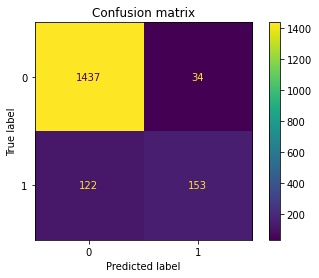

In [76]:
print("Матрица ошибок:", conf_matrix)

ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"]).plot()
plt.title('Confusion matrix')
plt.show()

Accuracy в данном случае описывает точность предсказания. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству. 

Модель  LGBM показала Accuracy 0.91 - это высокий показатель. Но на него не стоит ориентироваться, это связано с тем, что классы не сбалансированы, ушедших клиентов значительно меньше. В таком случае модель будет предсказывать больший класс чаще, соответственно и "угадывать" будет чаще, но при этом только 0 класс(которого больше), а 1 класс она может предсказывать плохо. 


Рассмотрим матрицу ошибок:

Модель правильно предсказала, что клиент останется в 1437 случаях из 1471 (98%), и ошиблась в 34 случаях (2%).
Модель правильно предсказала, что клиент уйдет в 153 случаях из 275 (56%), и ошиблась в 122 случаях (44%).

Проверим модель на адекdатность с помощью DummyClassifier. DummyClassifier не учитывает никаких особенностей данных и использует случайные значения для классификации - в нашем случае везде предсказывает превалирующий класс(0).

Accuracy на Dummy модели: 0.8424971363115693
Матрица ошибок Dummy модели: [[1471    0]
 [ 275    0]]


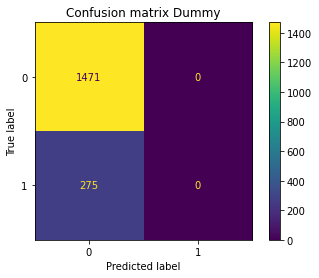

In [83]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(features_train_ord, target_train)
print('Accuracy на Dummy модели:', dummy_clf.score(features_test_ord, target_test))

conf_matrix_dummy = confusion_matrix(target_test, dummy_clf.predict(features_test_ord))
print('Матрица ошибок Dummy модели:', conf_matrix_dummy)

ConfusionMatrixDisplay(conf_matrix_dummy, display_labels=["0", "1"]).plot()
plt.title('Confusion matrix Dummy')
plt.show()

Случайная модель показала значение Accuracy 0.84 - на 84% модель предсказывает верно. Однако, такая модель предсказывает верно только больший класс - 0, а класс 1 она всегода предсказывает неверно. 

**Вывод:**
Лучшая из полученных моделей отработала хорошо. Метрика ROC-AUC показала 0.89 на тесте, это достаточно высокий показатель.
На основании матрицы ошибок можно сделать вывод, что модель хорошо предсказывает 0 класс - клиетов, которые не расторгнут договор, ошибаясь примерно в 2% случаев. 1 класс - ушедших пользователей, модель определяет хуже и в 44% случаев ошибается.

## Общий вывод.

##### Этап 1. Подготовка данных.
- В ходе этого этапа был открыты файлы (4 датасета), предоставленные заказчиком  и изучены данные. Была проведена проверка на пропуски и дубликаты. 
- Созданы новые признаки - длительность контракта и целевой признак (ушел клиент или остался). Столбец TotalCharges приведен к типу float64. Также удалены признаки, содержащие даты. Категориальный бинарный признак SeniorCitizen был преобразован в тип object.
- Далее 4 датасета были объеденины. 

В результате анализа и предобработки объединенного датасета были сделаны следующие шаги:
1. Найденные пропуски, заполнены константным значением. Причиной образования пропусков послужила объединение - не все клиенты компании используют оба тарифных пакета - интернет и стационарную телефонную связь.
2. Была изучена корреляция признаков от целевого признака. В результате были удалены два признака 'gender'(пол) и 'Dependents'(наличие детей), т.к. их влияние на таргет оказалось ничтожно мало, и не играет большой роли в построении предсказаний моделью.
3. Был изучен баланс классов. Дисбаланс оказался очень большой - 85/15. Было принято решение ничего с ним не делать, т.к. метрика ROC-AUC не чувствительна к дисбалансу. Уменьшение или увеличение выборки для баланса классов - не подходящая стратегия в данном исследовании. При подборе гиперпараметров проверили влияние class_weight='balanced', в результате лучшие показатели метрики получились без балансировки модели.

##### Этап 2. Обучение моделей
Были обучены три модели - LightGBM, Логистическая регрессия и Модель случайного леса - и были найдены наиболее подходящие гиперпараметры, благодаря которым модели выдавали наилучшее качество.

Лучшей моделью стала LightGBMClassifier, ее ROC-AUC показала на кросс-валидации 0.87. Параметры модели: 'class_weight': None, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 90. Наиболее важными признаками в процессе обучения модели также оказались contract_duration, MonthlyCharges, TotalCharges.

##### Этап 3. Тестирование
Модель LightGBM с наилучшими параметрами была протестирована, и показала значение ROC-AUC 0.90, что удовлетворяет условиям заказчика. модель хорошо предсказывает 0 класс - клиетов, которые не расторгнут договор, ошибаясь примерно в 3% случаев. 1 класс - ушедших пользователей, модель определяет хуже и в 44% случаев ошибается. Это связано с тем, что ушедших пользователей совсем немного, относительно остальных(дисбаланс), модели не хватает данных для обучения. И тем не менее она неплохо справилась.

##### Этап 4. Рекоммендации заказчику.
Корреляция между таргетом и остальными признаками довольно мала, сложно понять, из-за чего именно уходят клиенты. Наибольшая корреляция наблюдалась с такими признаками как длительность контракта, и суммой, потраченной клиетном за все время. т.е. чем дольше человек пользуется услугами компании, тем меньше вероятность ухода. Возможно, стоит задуматься о создании дополнительной системы лояльности для новых пользователей, чтобы они превращались в верных клиентов.